In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# 1. Load the CSV
df = pd.read_csv("severity_labels_cleaned.csv")

# 2. Extract disease labels
def get_disease_label(path):
    path = path.lower()
    if "covid19" in path:
        return 0
    elif "pneumonia" in path:
        return 1
    elif "normal" in path:
        return 2
    return -1

df["disease_label"] = df["image_path"].apply(get_disease_label)

# 3. Update image paths to point to the correct directory
def fix_path(x):
    folder = os.path.basename(os.path.dirname(x))
    filename = os.path.basename(x)
    return os.path.join("Data", folder, filename)

df["image_path"] = df["image_path"].apply(fix_path)

#  4. Filter out invalid labels (if any)
df = df[df["disease_label"] != -1]

#  5. Prepare NumPy arrays
image_paths = df["image_path"].values
disease_labels = df["disease_label"].values.astype(np.int32)
severity_labels = df["severity_numeric"].values.astype(np.int32)

#  6. Image parsing function
def parse_image(path, disease_label, severity_label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))  # ✅ This is important

    return image, {
        "disease_output": tf.cast(disease_label, tf.int32),
        "severity_output": tf.cast(severity_label, tf.int32)
    }

# 7. Create tf.data.Dataset
def create_dataset(paths, disease_labels, severity_labels, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, disease_labels, severity_labels))
    ds = ds.map(parse_image, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

# 8. Train-test split
train_paths, val_paths, train_disease, val_disease, train_severity, val_severity = train_test_split(
    image_paths, disease_labels, severity_labels,
    test_size=0.2, stratify=disease_labels, random_state=42
)

train_ds = create_dataset(train_paths, train_disease, train_severity)
val_ds = create_dataset(val_paths, val_disease, val_severity, shuffle=False)

# 9. Confirm it's working
for images, labels in train_ds.take(1):
    print("✅ Batch loaded.")
    print("Images shape:", images.shape)
    print("Disease Labels:", labels["disease_output"][:5])
    print("Severity Labels:", labels["severity_output"][:5])

✅ Batch loaded.
Images shape: (32, 224, 224, 3)
Disease Labels: tf.Tensor([1 2 1 1 1], shape=(5,), dtype=int32)
Severity Labels: tf.Tensor([2 1 2 2 2], shape=(5,), dtype=int32)


In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121

# Input layer
input_layer = layers.Input(shape=(224, 224, 3))

# Backbone
base_model = DenseNet121(include_top=False, input_tensor=input_layer, weights='imagenet', pooling='avg')
base_model.trainable = False  # Optional: You can fine-tune later

# Shared representation
shared = layers.Dense(256, activation='relu')(base_model.output)

# Task 1: Disease classification (3 classes)
disease_output = layers.Dense(3, activation='softmax', name='disease_output')(shared)

# Task 2: Severity classification (3 classes)
severity_output = layers.Dense(3, activation='softmax', name='severity_output')(shared)

# Define model
model = models.Model(inputs=input_layer, outputs=[disease_output, severity_output])

# Compile
model.compile(
    optimizer='adam',
    loss={
        "disease_output": "sparse_categorical_crossentropy",
        "severity_output": "sparse_categorical_crossentropy"
    },
    metrics={
        "disease_output": "accuracy",
        "severity_output": "accuracy"
    }
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,446 (27.85 MB)

 Trainable params: 263,942 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [25]:
for x, y in train_ds.take(1):
    print("Image batch shape:", x.shape)
    print("Label keys:", y.keys() if isinstance(y, dict) else type(y))
    print("Disease Labels:", y["disease_output"])
    print("Severity Labels:", y["severity_output"])

Image batch shape: (32, 224, 224, 3)
Label keys: dict_keys(['disease_output', 'severity_output'])
Disease Labels: tf.Tensor([2 0 1 1 1 1 1 1 1 1 1 1 2 0 2 1 2 1 1 1 1 1 1 2 1 2 1 2 1 2 1 1], shape=(32,), dtype=int32)
Severity Labels: tf.Tensor([1 0 2 2 1 1 1 1 2 2 2 2 1 0 1 1 1 2 1 2 1 1 1 1 2 1 2 1 2 1 1 1], shape=(32,), dtype=int32)


In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # You can increase for better performance
)

Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - disease_output_accuracy: 0.9592 - disease_output_loss: 0.1142 - loss: 0.1727 - severity_output_accuracy: 0.9735 - severity_output_loss: 0.0586 - val_disease_output_accuracy: 0.9433 - val_disease_output_loss: 0.1522 - val_loss: 0.2162 - val_severity_output_accuracy: 0.9759 - val_severity_output_loss: 0.0625
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - disease_output_accuracy: 0.9549 - disease_output_loss: 0.1167 - loss: 0.2073 - severity_output_accuracy: 0.9640 - severity_output_loss: 0.0906 - val_disease_output_accuracy: 0.9557 - val_disease_output_loss: 0.1275 - val_loss: 0.1890 - val_severity_output_accuracy: 0.9751 - val_severity_output_loss: 0.0588
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - disease_output_accuracy: 0.9586 - disease_output_loss: 0.1091 - loss: 0.1608 - severity_output_accuracy: 0.9792 - severity_output_loss: 0.0516 - val_disease_output_accuracy: 0.9363 - val_disease_output_loss: 0.1695 - val_l

In [34]:
val_loss, val_disease_loss, val_severity_loss, val_disease_acc, val_severity_acc = model.evaluate(val_ds)
print(f"Validation Disease Accuracy: {val_disease_acc:.4f}")
print(f"Validation Severity Accuracy: {val_severity_acc:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - disease_output_accuracy: 0.9545 - disease_output_loss: 0.1137 - loss: 0.1703 - severity_output_accuracy: 0.9786 - severity_output_loss: 0.0565
Validation Disease Accuracy: 0.9604
Validation Severity Accuracy: 0.9782


In [37]:
model.save("../models/multi_task_chest_xray_model.h5")

In [39]:
def predict_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, 0)  # Add batch dim

    disease_pred, severity_pred = model.predict(image)
    disease_label = np.argmax(disease_pred[0])
    severity_label = np.argmax(severity_pred[0])

    disease_names = ['COVID19', 'NORMAL','PNEUMONIA']
    severity_names = ['Mild', 'Moderate', 'Severe']

    if disease_label == 2:  # Normal case
        print(f"Disease: {disease_names[disease_label]}")
    else:
        print(f"Disease: {disease_names[disease_label]}")
        print(f"Severity: {severity_names[severity_label]}")

In [41]:
predict_image("COVID19(10).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Disease: COVID19
Severity: Mild


In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, output_head='disease_output'):
    # Create a model that maps the input image to activations + output
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.get_layer(output_head).output]
    )

    # GradientTape to compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply gradients with activation outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [47]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

D:\Ana\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_862']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


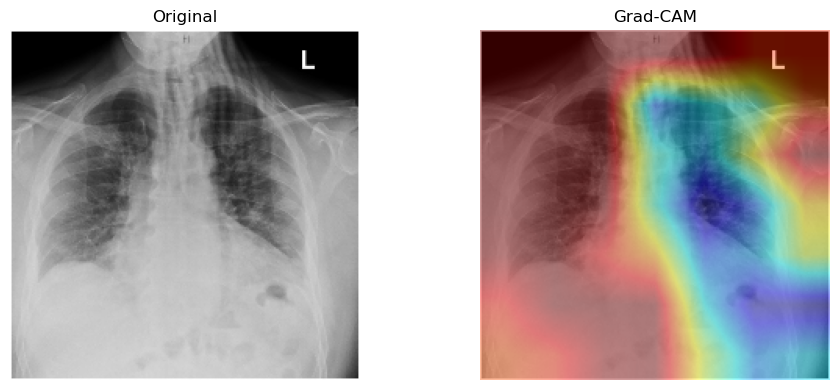

In [49]:
def run_gradcam_on_image(img_path, model, output_head='disease_output'):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.float32) / 255.0

    last_conv_layer_name = get_last_conv_layer(model)

    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name, output_head=output_head)
    save_and_display_gradcam(img_path, heatmap)
sample_path = "COVID19(10).jpg"  # change to an actual image path from your dataset
run_gradcam_on_image(sample_path, model, output_head='disease_output')

D:\Ana\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_862']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


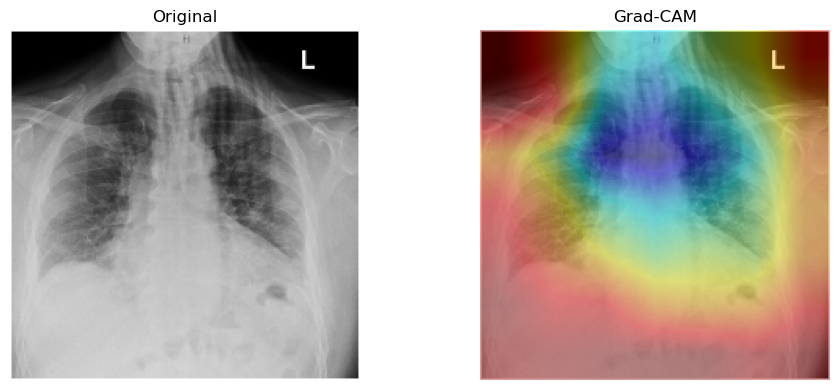

In [51]:
run_gradcam_on_image(sample_path, model, output_head='severity_output')

In [53]:
model.save("model/multitask_model.h5")

In [55]:
model.save("../models/multitask_model.h5")